In [1]:
import torch
import triton
import triton.language as tl

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [82]:
class MAX_INDICES:
    def __init__(self, values, indices):
        self.values = values
        self.indices = indices

@triton.jit
def _max_short(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr):
    
    start_m = tl.program_id(0)
    input_offset = start_m * BLOCK_M * stride0
    input_ptrs = INPUT + input_offset +  tl.arange(0, BLOCK_M)[:, None] * stride0 + tl.arange(0, BLOCK_N)[None, :]
    mask_row = (start_m * BLOCK_M + tl.arange(0, BLOCK_M)[:, None]) < M
    mask_col = tl.arange(0, BLOCK_N) < N
    mask = mask_row & mask_col
    inp = tl.load(input_ptrs, mask=mask, other=float('-inf'))
    max_num, index = tl.max(inp, -1, return_indices=True)
    output_ptrs = VALUES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(output_ptrs, max_num, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)
    indices_ptrs = INDICES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(indices_ptrs, index, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)

@triton.jit
def _max_long(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_N: tl.constexpr):
    start_m = tl.program_id(0)
    base_ptrs = INPUT + start_m * stride0


    INPUT_ptrs = base_ptrs + tl.arange(0, BLOCK_N)
    mask = tl.arange(0, BLOCK_N) < N
    inp = tl.load(INPUT_ptrs, mask=mask)
    max_num, indices = tl.max(inp, 0, return_indices=True)  

    for start_n in range(BLOCK_N, N, BLOCK_N):
        INPUT_ptrs = base_ptrs + start_n  + tl.arange(0, BLOCK_N)
        mask = (start_n + tl.arange(0, BLOCK_N)) < N
        inp = tl.load(INPUT_ptrs, mask=mask)
        new_max_num, new_indices = tl.max(inp, 0, return_indices=True)  
        if new_max_num > max_num:
            max_num = new_max_num
            indices = start_n + new_indices

    tl.store(VALUES + start_m, max_num)
    tl.store(INDICES + start_m, indices)

def triton_max(tensor, axis=-1):
    # tensor = tensor.unsqueeze(-1)
    # if axis < 0:
    #     axis -= 1
    # tensor = tensor.transpose(axis, -1).squeeze(axis)
    tensor = torch.movedim(tensor, axis, -1)
    tensor_shape = tensor.shape
    tensor = tensor.reshape(-1, tensor_shape[-1])
    B,D = tensor.shape
    values = torch.empty(B, device=tensor.device, dtype=tensor.dtype)
    indices = torch.empty(B, device=tensor.device, dtype=torch.int64)
    if D <=256:
        tmp = triton.next_power_of_2(B)
        BLOCK_M= min(256, tmp)
        BLOCK_N=triton.next_power_of_2(D)
        grid = lambda meta: (triton.cdiv(B, meta['BLOCK_M']),)
        _max_short[grid](tensor, values, indices,
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    else:
        BLOCK_N = min(triton.next_power_of_2(D), 32*1024)
        _max_long[(B,)](tensor, values, indices, 
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    return MAX_INDICES(values.reshape(*tensor_shape[:-1]),indices.reshape(*tensor_shape[:-1]))

In [83]:
x = torch.randn(64,64,64).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))
x = torch.randn(8,1, 64*1024).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))

True
True
True
True


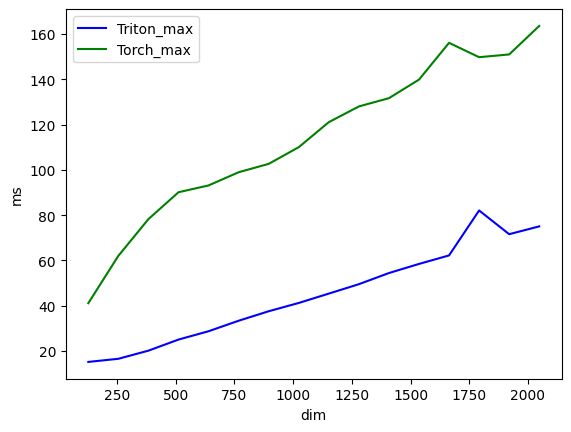

triton max:
       dim  Triton_max   Torch_max
0    128.0   15.207524   41.144941
1    256.0   16.596926   62.077954
2    384.0   20.186229   78.286707
3    512.0   25.079712   90.151288
4    640.0   28.757589   93.148679
5    768.0   33.394888   98.977111
6    896.0   37.585285  102.680102
7   1024.0   41.249316  110.044681
8   1152.0   45.383044  121.099174
9   1280.0   49.535252  128.038734
10  1408.0   54.457534  131.690979
11  1536.0   58.487967  139.887884
12  1664.0   62.238835  156.127676
13  1792.0   82.097143  149.790287
14  1920.0   71.617678  151.004493
15  2048.0   75.073436  163.599417


In [97]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2048, 'seq_len':16, 'axis': 0}
    ))
def benchmark(bs, seq_len, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


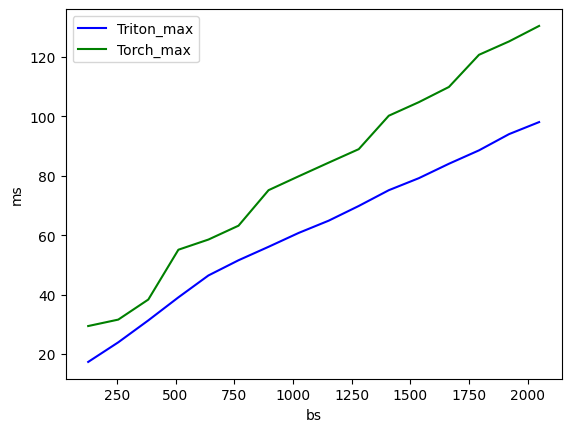

triton max:
        bs  Triton_max   Torch_max
0    128.0   17.309254   29.397694
1    256.0   23.911353   31.566683
2    384.0   31.307530   38.327739
3    512.0   39.058652   55.105995
4    640.0   46.440512   58.534641
5    768.0   51.557831   63.204676
6    896.0   56.092680   75.167738
7   1024.0   60.760908   79.844028
8   1152.0   64.895041   84.445752
9   1280.0   69.846131   88.989392
10  1408.0   75.161733  100.254834
11  1536.0   79.214543  104.821801
12  1664.0   84.070049  109.941080
13  1792.0   88.583387  120.776653
14  1920.0   94.051920  125.281215
15  2048.0   98.107740  130.504906


In [95]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 2048, 'seq_len':16, 'axis': -1}
    ))
def benchmark(bs, seq_len, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


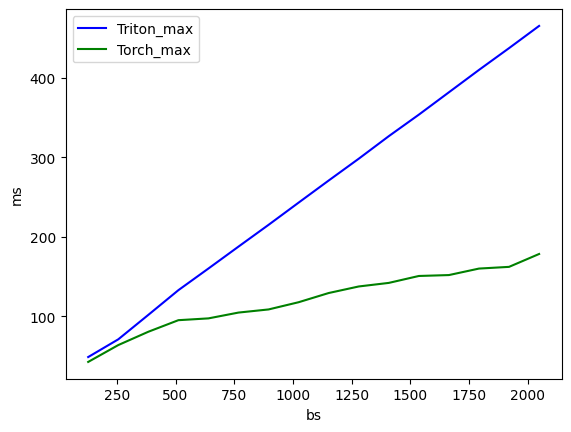

triton max:
        bs  Triton_max   Torch_max
0    128.0   48.626687   42.489696
1    256.0   70.890099   63.678153
2    384.0  101.656638   80.427110
3    512.0  132.717624   94.976299
4    640.0  159.964398   97.247131
5    768.0  187.529176  104.553558
6    896.0  214.890078  108.487837
7   1024.0  242.832541  117.571123
8   1152.0  270.630270  129.138798
9   1280.0  298.052639  137.382612
10  1408.0  326.417416  141.872883
11  1536.0  353.485227  150.579900
12  1664.0  381.606042  151.723534
13  1792.0  409.720600  159.891218
14  1920.0  437.108636  162.035048
15  2048.0  465.050846  178.233132


In [96]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 16, 'seq_len':2048, 'axis': 1}
    ))
def benchmark(bs, seq_len, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
